In [1]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scirpy as ir
import numpy as np
import pathlib
import muon as mu
from muon import prot as pt
import os
import numpy as np
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models


def tissue_colors():
    tissue_color_dict = {
             'PBMC': '#d6616b',
             'BM': '#cedb9c',
             'LN': '#8c6d31',
             'SPL': '#393b79'}
    return tissue_color_dict

overload = False
if overload == True:
    output_dir='figures/overload'
else:
    output_dir = "figures/no_overload"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save = 300)
sc.set_figure_params(format = 'png')
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None
donor = 'TBD6'
data = '/home/michaelswift/repos/tabula-bursa/data/10X'
samples = ['LN', 'SPL', 'PBMC', 'BM']

def load_data(samplenames, data, donor, overload, tenX_output):
    """samplename is a list of samplenames / tissue names, 
    data is where the data were downloaded
    donor is the name of the donor
    all of these info are used to create the file path
    """
    mdatas = []
    for sample in samples:
        if tenX_output == 'raw':
            datapath = '{}/{}_{}/outs/multi/count/raw_feature_bc_matrix/'.format(data, donor, sample)
            print(datapath)
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
        if tenX_output == 'filtered':
            datapath = '{}/{}_{}/outs/per_sample_outs/{}_{}/count/sample_feature_bc_matrix/'.format(data, donor, sample, donor ,sample)
            print(datapath)
            
            mdata = mu.read_10x_mtx(datapath)
            mdata['rna'].obs['tissue'] = sample
            mdatas.append(mdata)
            
    adatas = []
    for mdata in mdatas:
        adata = mdata['rna']
        adatas.append(adata)
    if overload == True:
        analysis = "with_overload"
    else:
        analysis = "without_overload"
    if overload:
    # hard coded number of samples right now
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], adatas[6], adatas[7])
    else:
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3])
    return adata

def perform_qc(adata):    
    # calculate qc metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    #adata = adata[:,~adata.var.index.str.contains('HSP|DNAJ')]
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    sc.pl.highest_expr_genes(adata,save='prefilter')
    # plot qc metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='prefilter')
    # cell filter
    sc.pp.filter_cells(adata, min_counts=500)
    sc.pp.filter_cells(adata, max_counts=80000)
    adata = adata[adata.obs['pct_counts_mt'] < 9]
    # plot results of filtering
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='postfilter')
    sc.pl.highest_expr_genes(adata, save='postfilter')
    return adata

In [2]:
def _merge_adata_vdj(vdj, adata):
    # construct merge columns
    adata.obs['cb_index']=adata.obs.index
    adata.obs['cb'] = adata.obs['cb_index'].str.split('-', expand=True)[0]
    adata.obs['cb_sample_id'] = adata.obs['cb'].astype(str) + '_' + adata.obs['tissue'].astype(str)
    vdj['cb_sample_id'] = vdj['cb'] + '_' + vdj['sample_id']
    # PBL vs PBMC
    vdj['cb_sample_id'] = vdj['cb_sample_id'].str.replace('PBL', 'PBMC')
    print(vdj.shape[0], "vdj / cbs")
    print(vdj.drop_duplicates('cb_sample_id').shape[0], "single vdj with single cb")
    print('dropping multiple vdj cbs')
    vdj = vdj.drop_duplicates('cb_sample_id')
    print('merging vdjs gex')
    merged = pd.merge(adata.obs, vdj, left_on='cb_sample_id', right_on='cb_sample_id')
    print(merged.shape[0], "cells after merging VDJs")
    merged.set_index('cb_index', inplace=True)
    adata = adata[adata.obs.index.isin(merged.index)]
    adata.obs = merged
    return adata

In [3]:
adata_1 = sc.read_h5ad('../../data/processed_h5ad/filtered_object.h5ad')
vdj = pd.read_table('../../../shared_data/cell_calls_full/TBD6_called_cells_combined_vdjc_lineage_ids_vseq_germ_blast.tsv.gz')
adata_1 = _merge_adata_vdj(vdj, adata_1)
# activated B cells data
adata_2 = sc.read_h5ad('/home/michaelswift/repos/seqclone3/notebooks/data/forseqclone.h5ad')
adata_2.obs['tissue'] = adata_2.obs.lane
print(adata_2.shape[0], "cells in comparison dataset")
adata = adata_1.concatenate(adata_2)

print(adata.shape[0], 'cells in combined dataset')

99196 vdj / cbs
91863 single vdj with single cb
dropping multiple vdj cbs
merging vdjs gex
36189 cells after merging VDJs
84380 cells in comparison dataset
120569 cells in combined dataset


## Filter out worst cells

In [4]:
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, max_counts=80000)

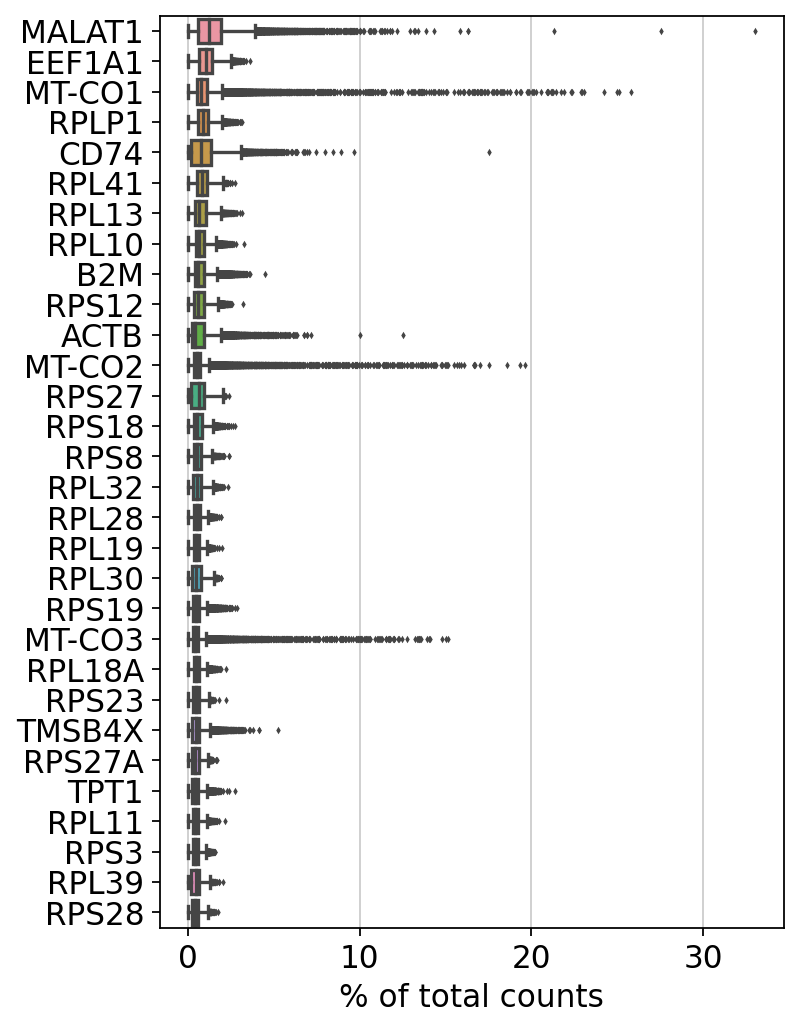

... storing 'tissue' as categorical
... storing 'cb_x' as categorical
... storing 'cb_sample_id' as categorical
... storing 'sample_id' as categorical
... storing 'cb_y' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'c_call' as categorical
... storing 'locus' as categorical
... storing 'stop_codon' as categorical
... storing 'vj_in_frame' as categorical
... storing 'productive' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'j_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignm

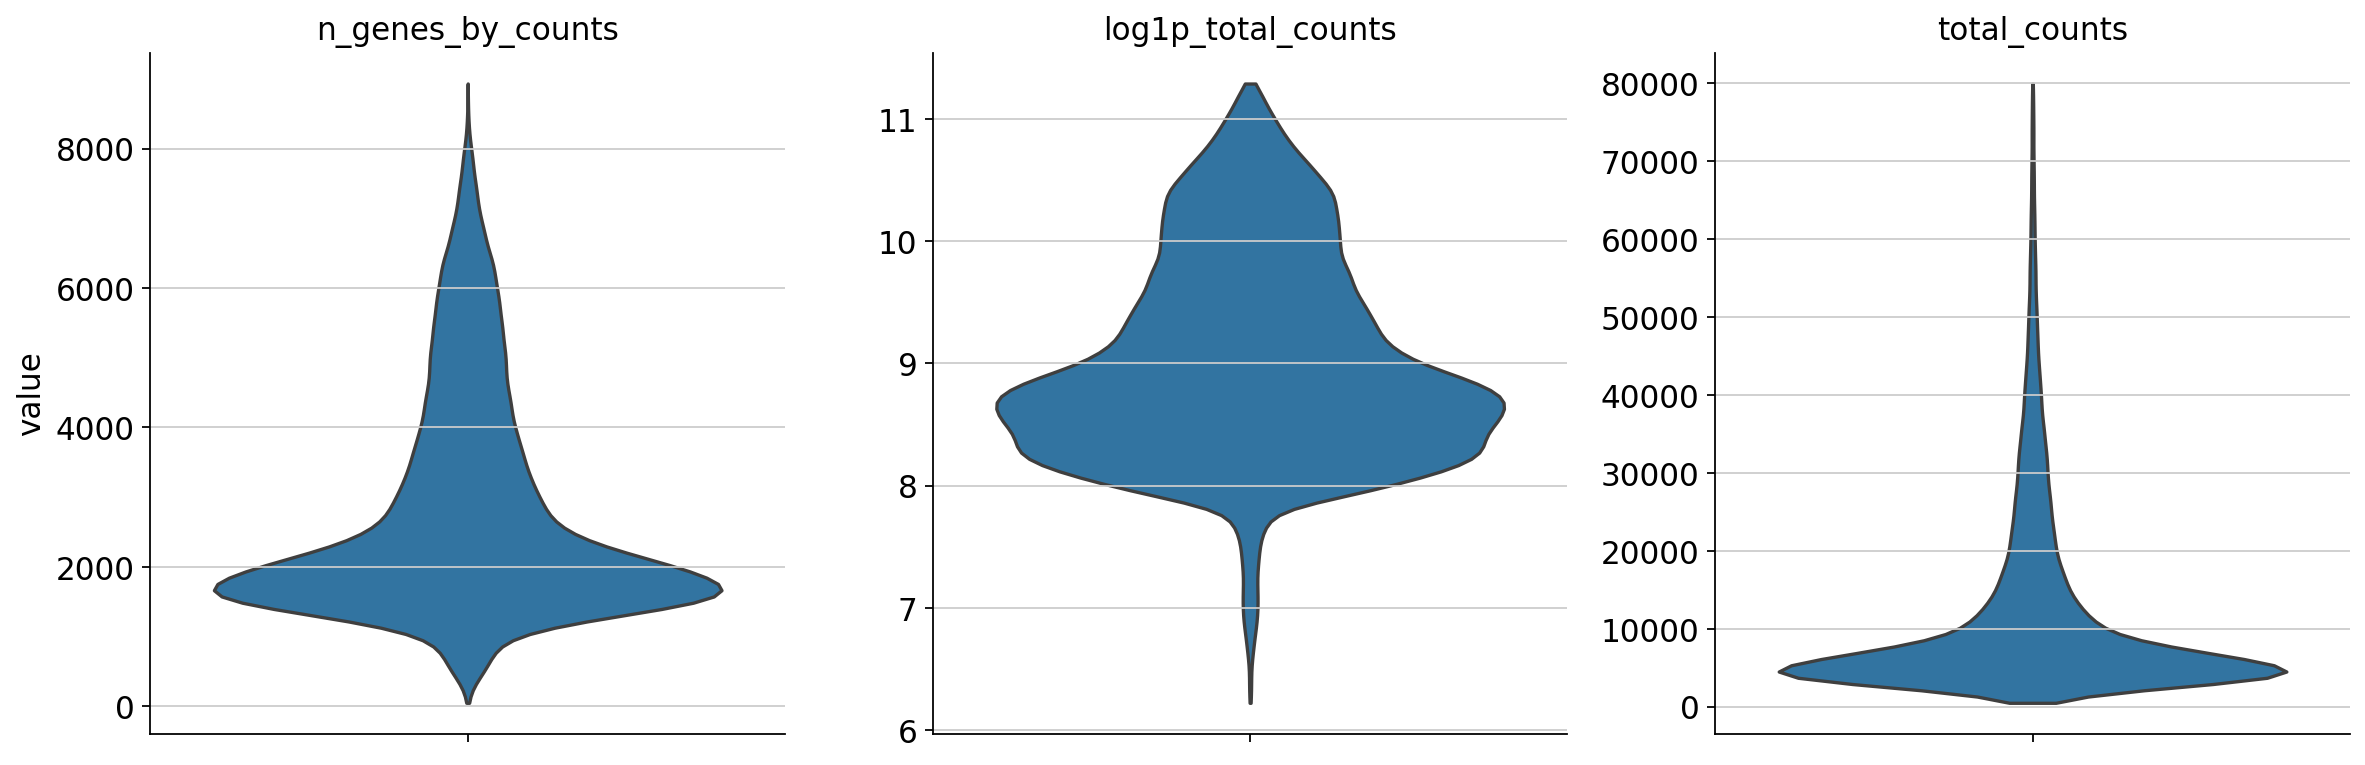

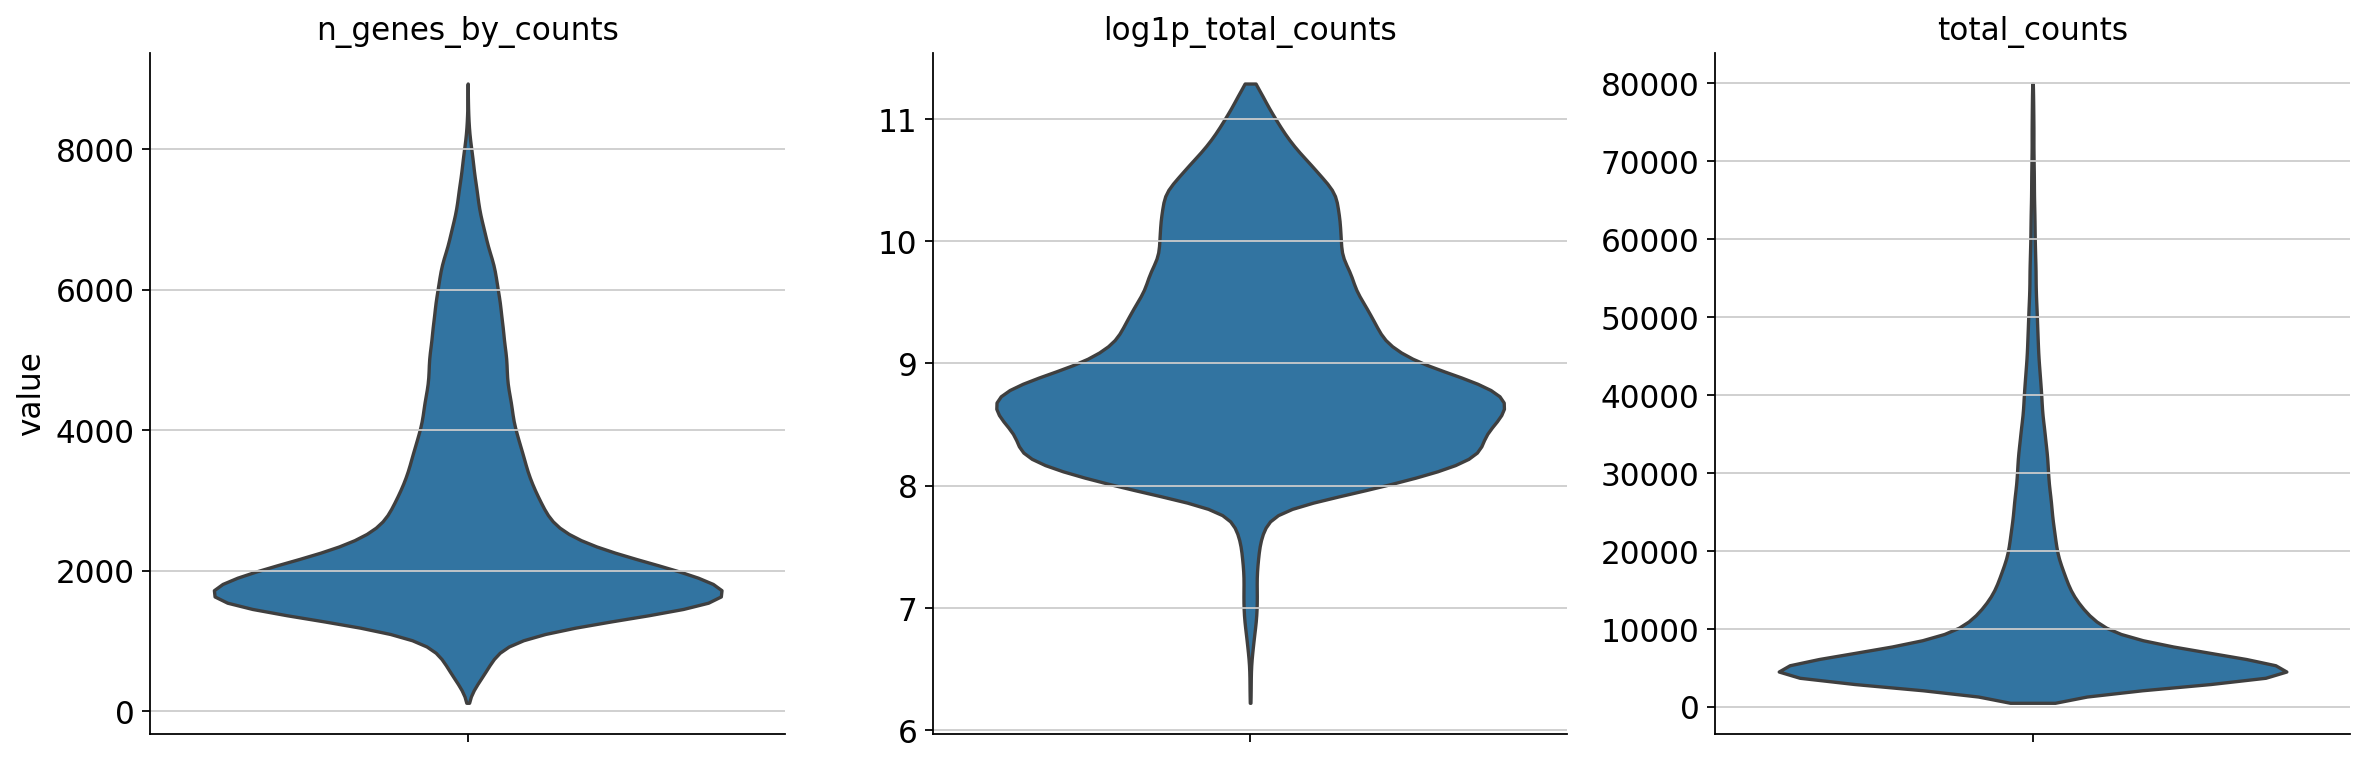

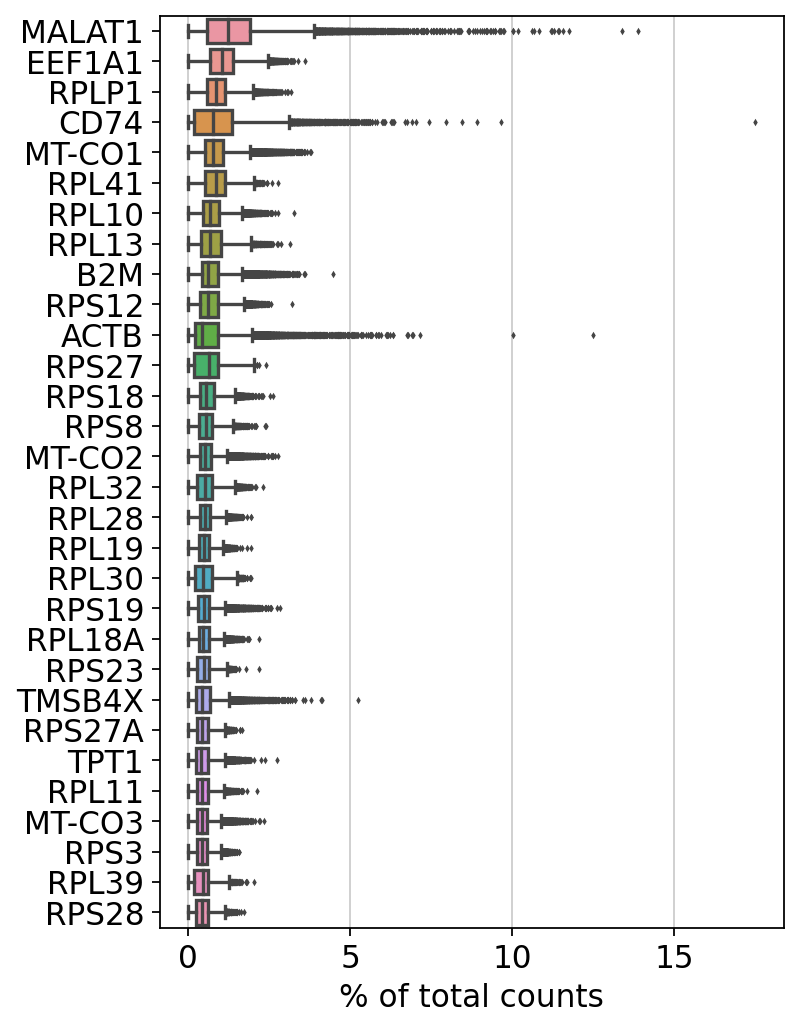

In [5]:
# generally this only filters out cells with > 9 % mito reads, which typically indicates they are dead
adata = perform_qc(adata)

In [6]:
def precluster_pp(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata, base = 2)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000)
    sc.pl.highly_variable_genes(adata)
    adata.raw = adata
    sc.pp.scale(adata, max_value = 10)
    return adata

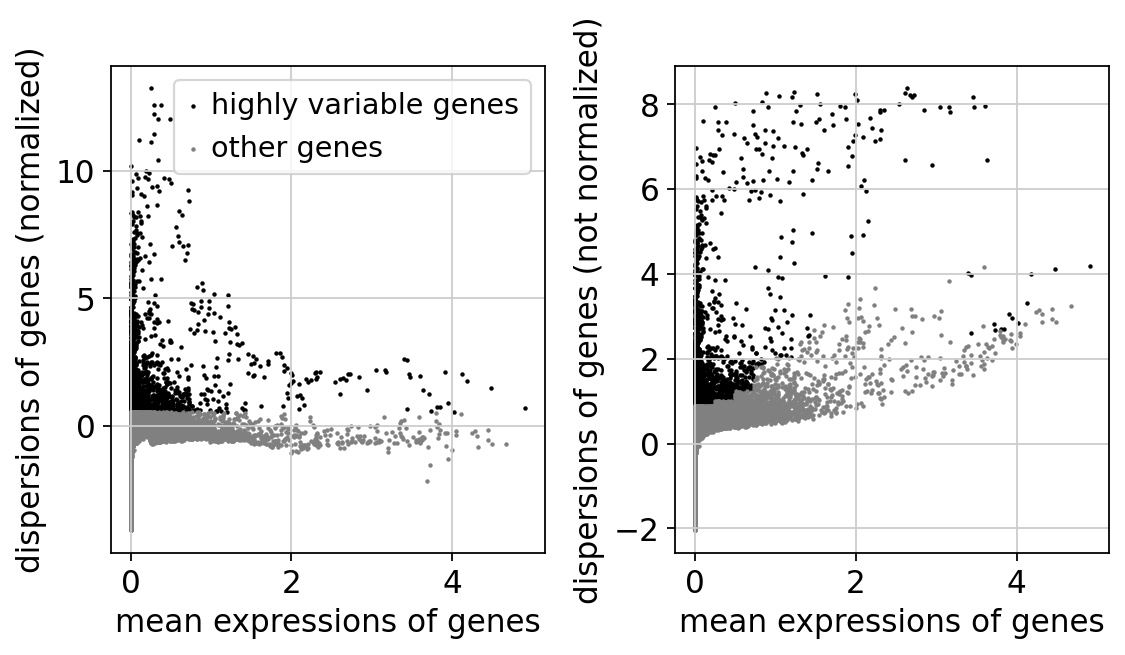

In [7]:
adata = precluster_pp(adata)

In [8]:
# remove variable igg genes which often drive clustering
adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False

# Cluster the data without batch correction

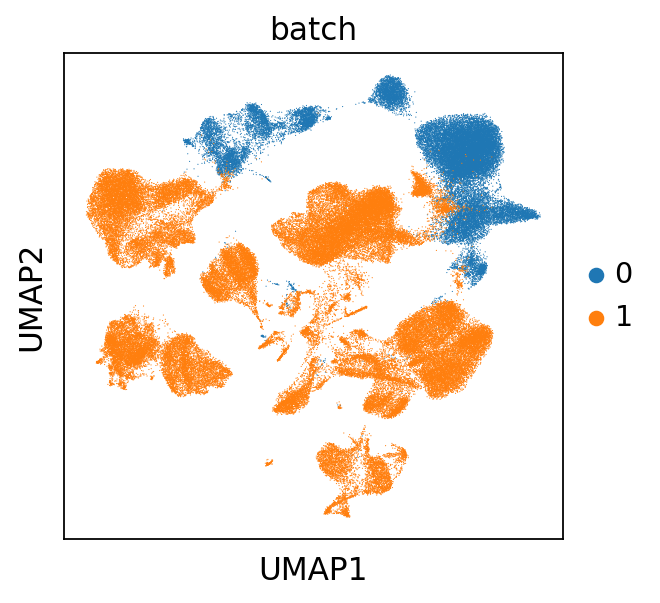

In [9]:
def cluster(adata, batch_correct, batch_key):
    sc.pp.pca(adata)
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = 'batch')
    return adata
adata = cluster(adata, batch_correct=False, batch_key = 'tissue')

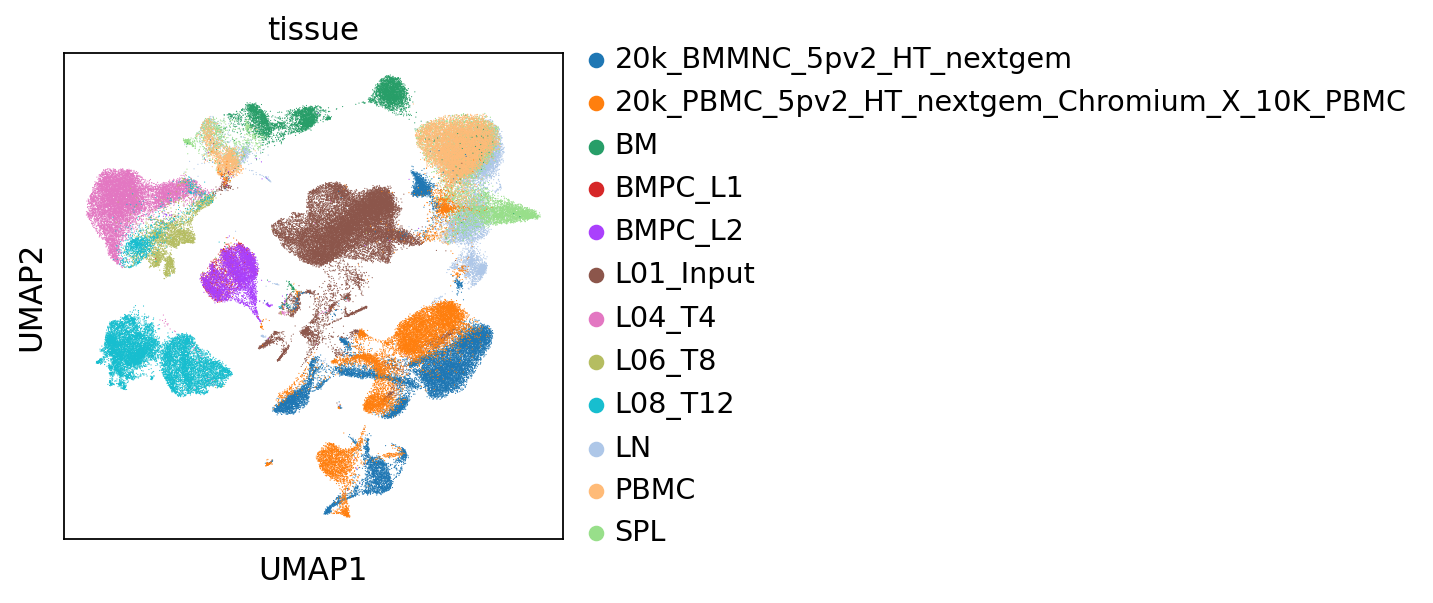

In [10]:
sc.pl.umap(adata, color = 'tissue')

## Use Celltypist

In [11]:
#Download all the available models.
#models.download_models()
#Update all models by re-downloading the latest versions if you think they may be outdated.
#models.download_models(force_update = True)

#Provide the input as an `AnnData`.
#predictions = celltypist.annotate('data/bcells.h5ad', model = 'Immune_All_Low.pkl', majority_voting=True)
#Alteadatatively, the input can be specified as an `AnnData` already loaded in memory.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
# Celltypist Annotations to bcells object
adata.obs['celltypist'] = predictions.predicted_labels.majority_voting

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 114869 cells and 30019 genes
🔗 Matching reference genes in the model
🧬 6099 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


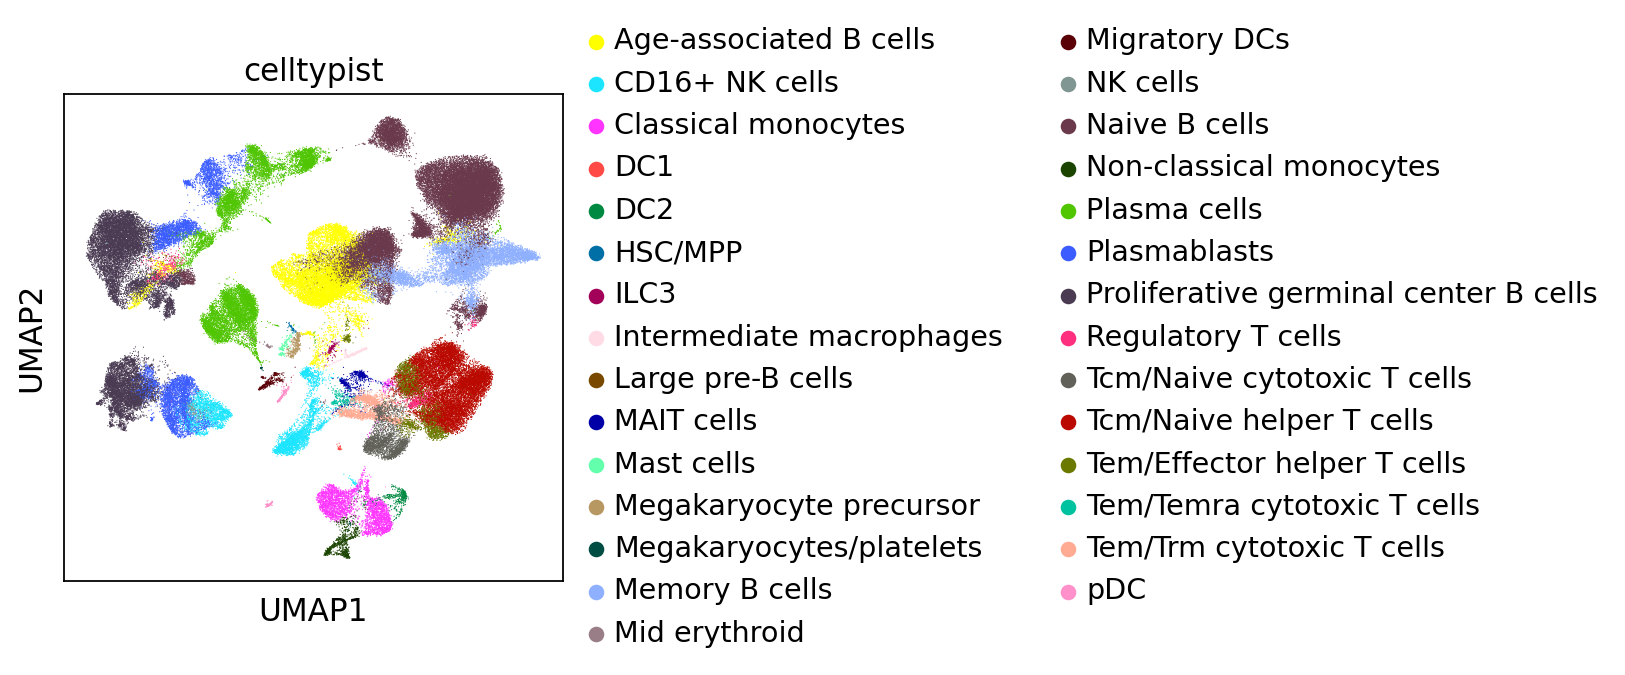

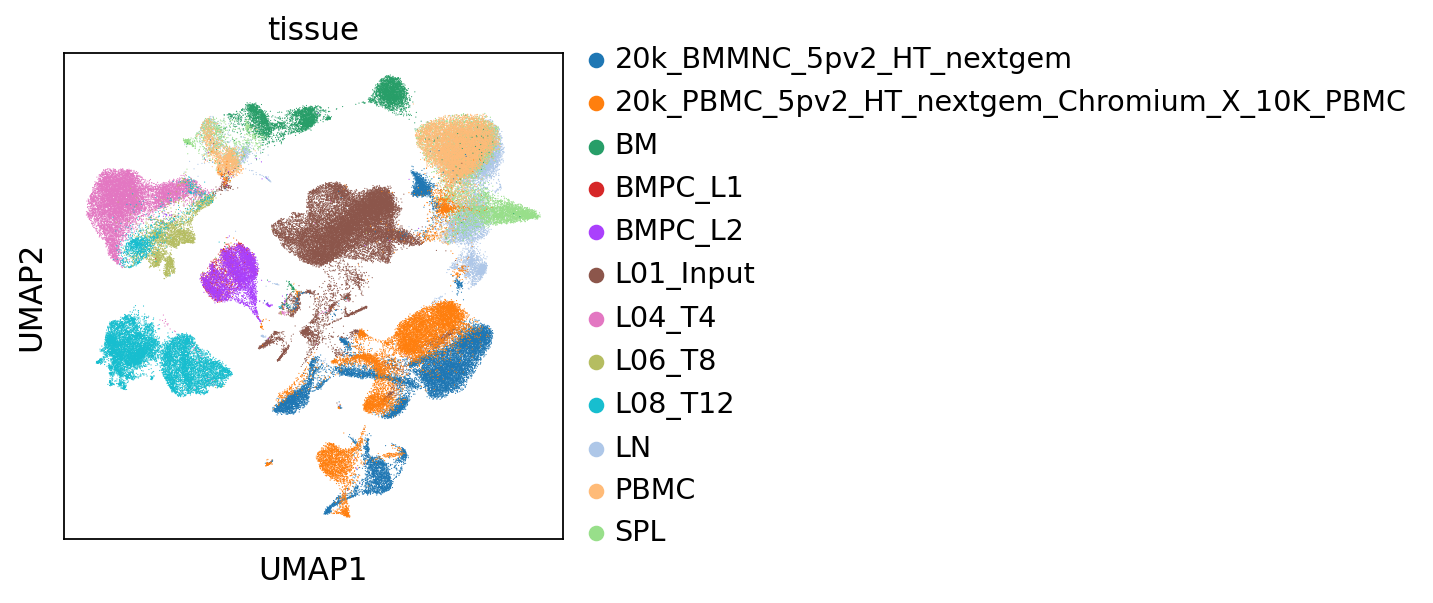

In [12]:
sc.pl.umap(adata, color = 'celltypist')
sc.pl.umap(adata, color = 'tissue')

In [13]:
# subset to b cell lineage
bcells = adata[adata.obs.celltypist.str.contains('B cells|Plasma')]

In [14]:
bcells.obs.celltypist = bcells.obs.celltypist.cat.remove_unused_categories()

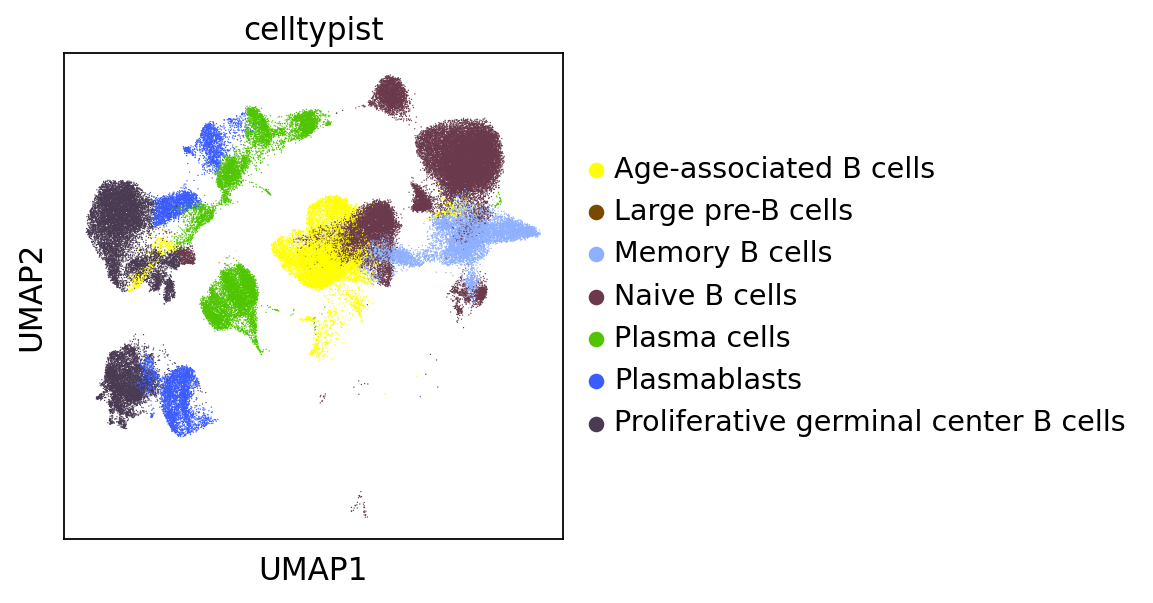

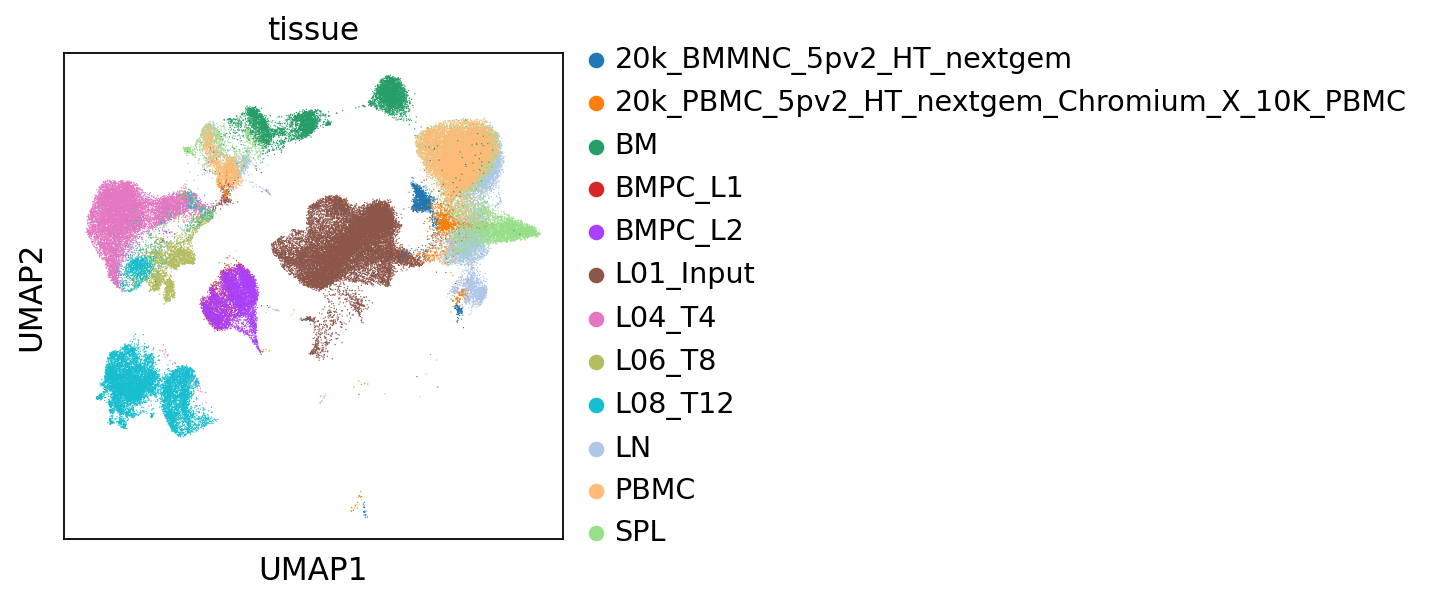

In [15]:
sc.pl.umap(bcells, color = 'celltypist')
sc.pl.umap(bcells, color = 'tissue')

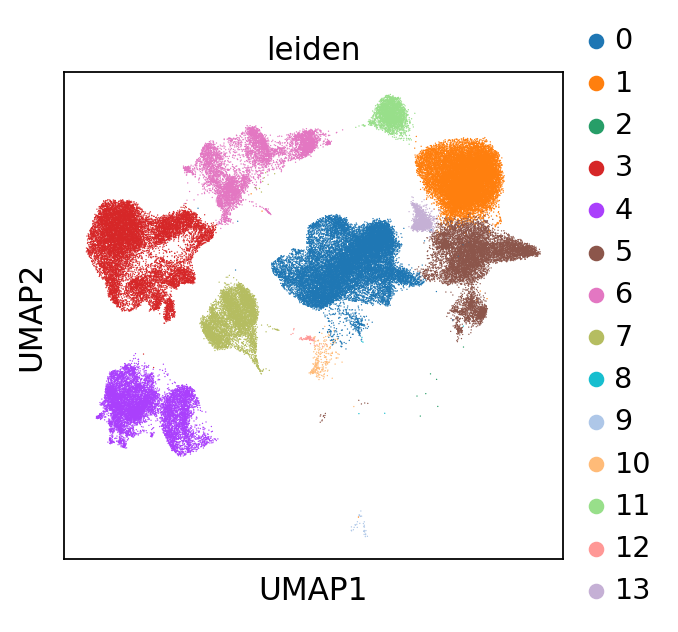

In [16]:
sc.pl.umap(bcells, color = 'leiden')

My suspicion is that cluster 7 is not bona-fide plasma cells

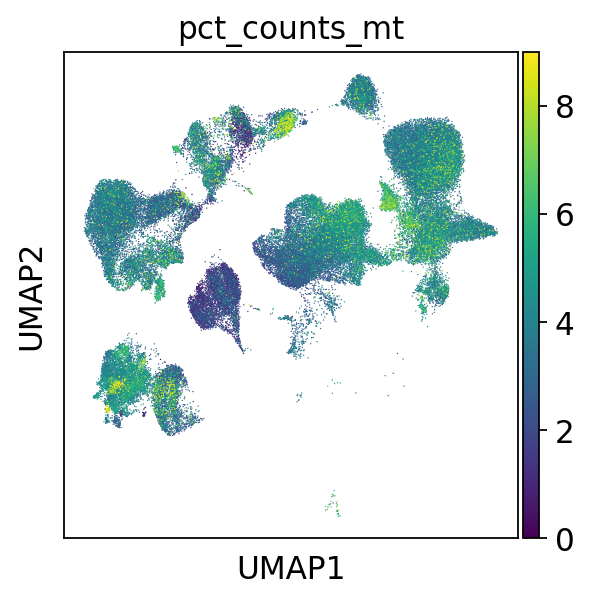

In [17]:
sc.pl.umap(bcells, color = 'pct_counts_mt')

In [ ]:
sc.pl.umap(bcells, color='leiden')

sc.tl.rank_genes_groups(bcells, groupby='leiden')

sc.tl.dendrogram(bcells, groupby='leiden')

sc.pl.rank_genes_groups_dotplot(bcells, groupby='leiden')

In [18]:
# removing leiden 4 which are dead cells / NK cells
# and leiden 2 & 8 which seem to have a lot of CD3,
# and leiden 10, 12 which also has quite a bit of perforin / SPINK2 / EGFL7 which are NK
bcells.obs['ambient_gene_expression'] = bcells.obs.leiden.isin(['4', '2', '8', '10', '12'])

In [19]:
# create high ambient gene expression column
bcells.obs['ambient_gene_expression'] = bcells.obs['ambient_gene_expression'].astype(str)

... storing 'ambient_gene_expression' as categorical


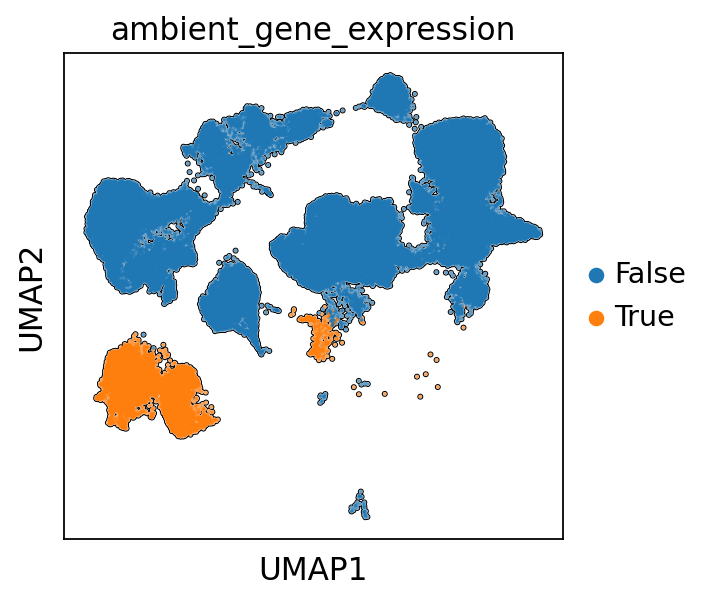

In [20]:
sc.pl.umap(bcells, color = 'ambient_gene_expression', size = 10, add_outline=True)

In [ ]:
# check out total counts

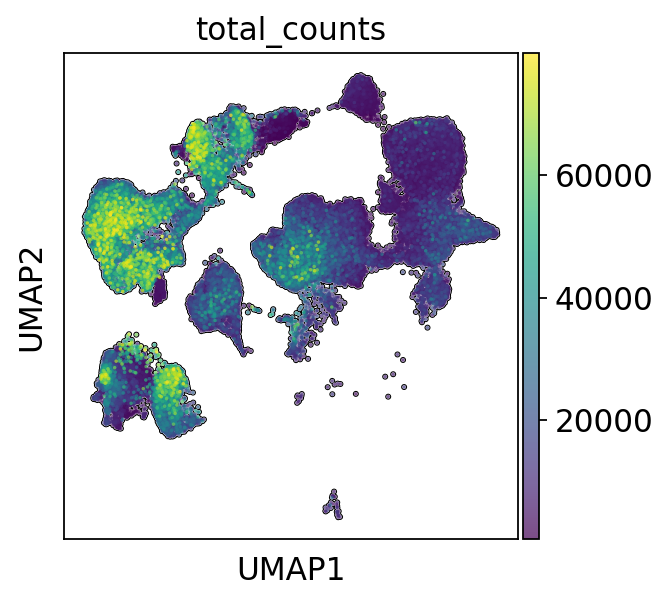

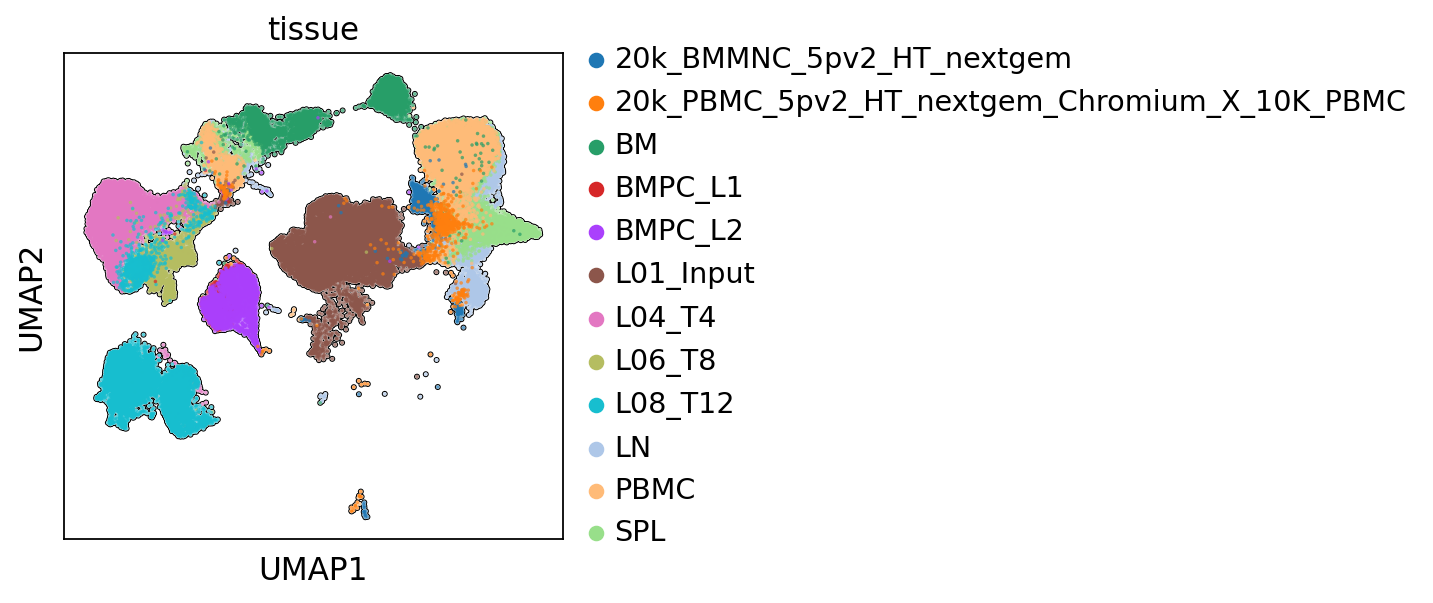

In [21]:
sc.pl.umap(bcells, color = 'total_counts', size = 10, add_outline=True)
sc.pl.umap(bcells, color = 'tissue', size = 10, add_outline=True)

In [ ]:
# view actual distributions of counts (hump in lane 06 is odd for sure)

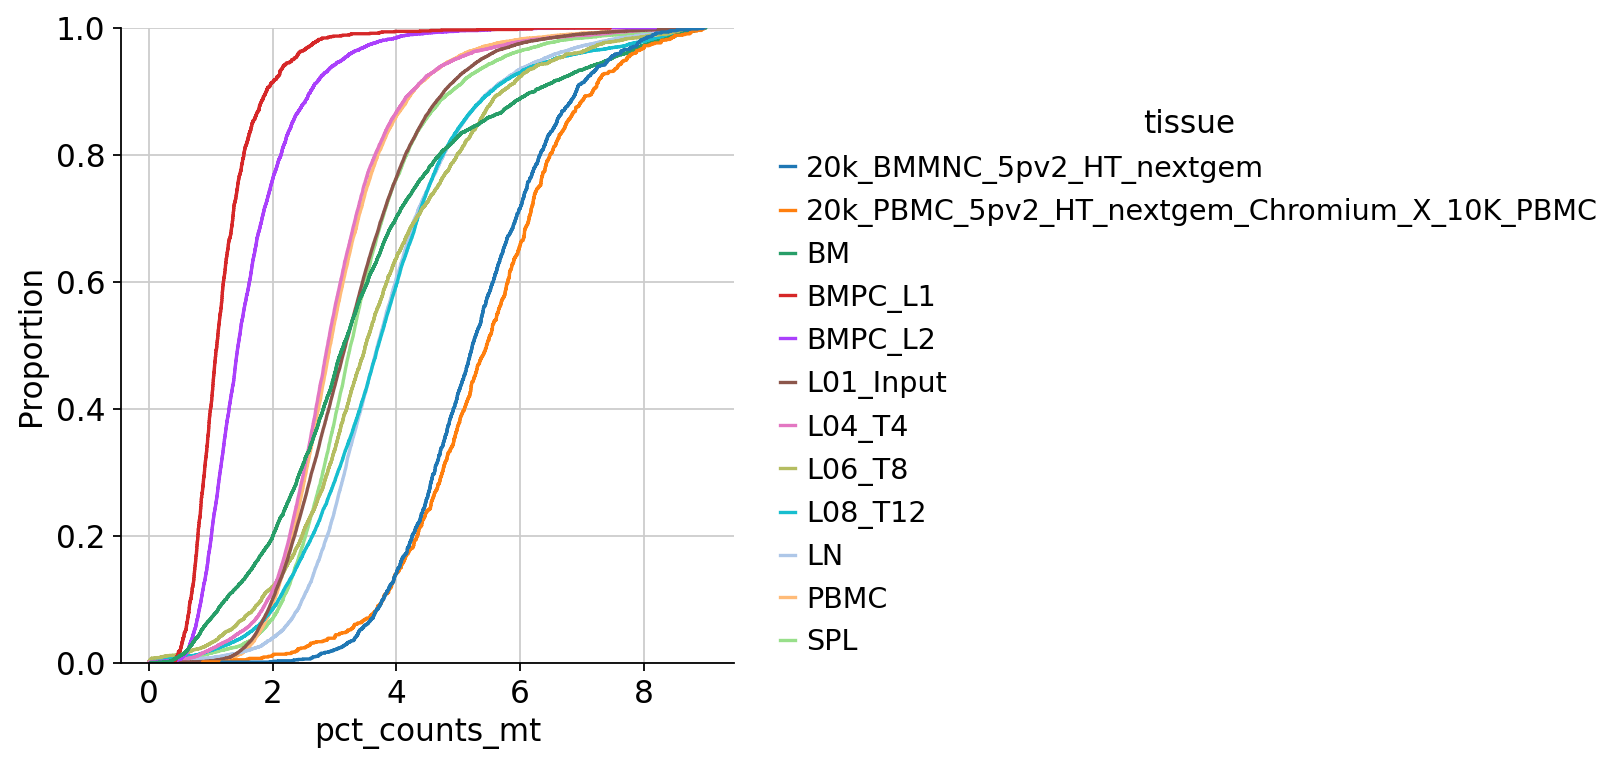

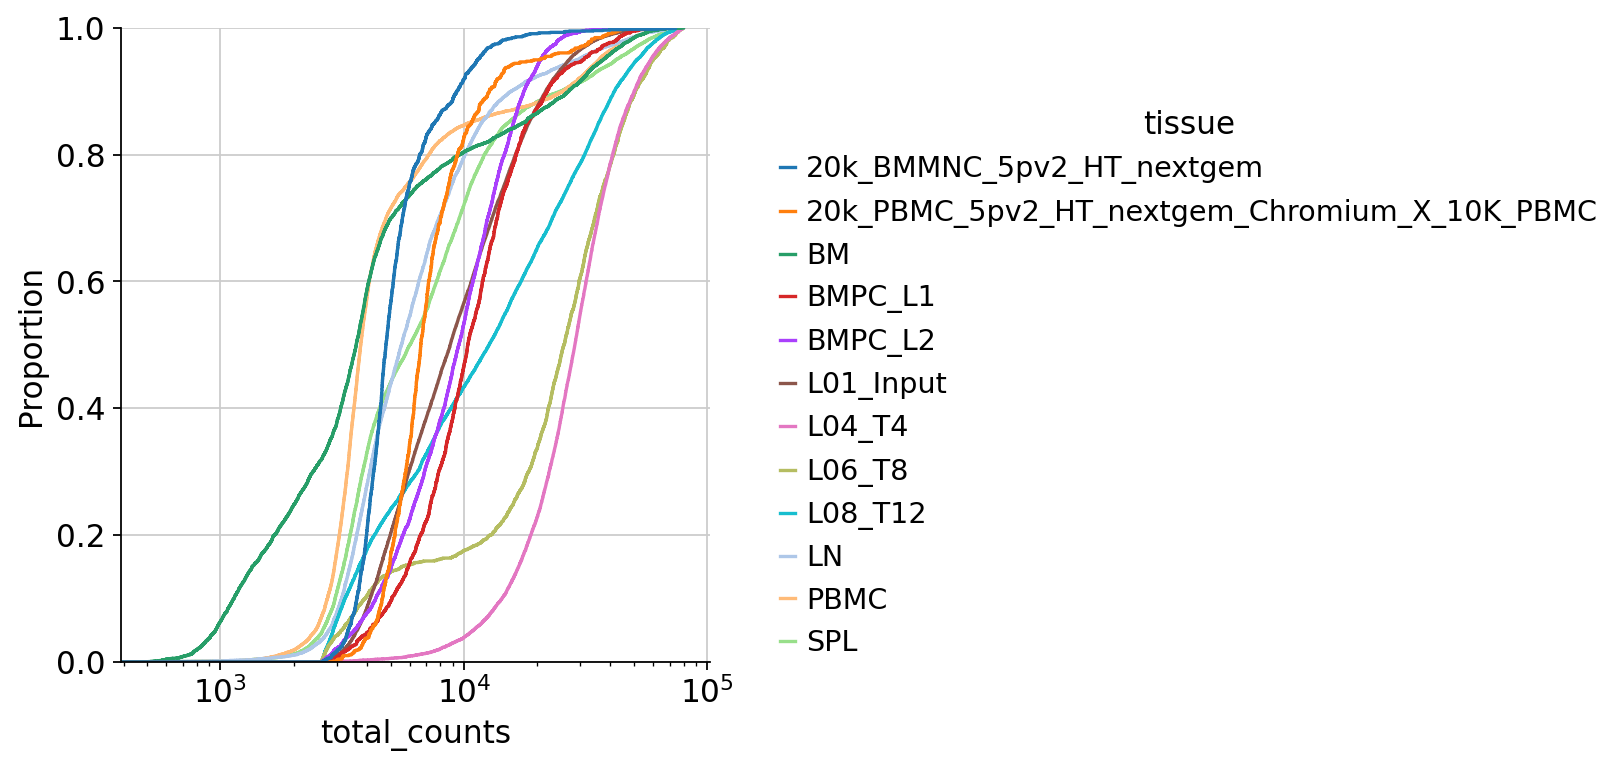

In [22]:
sns.displot(data = bcells.obs, x='pct_counts_mt', kind='ecdf', hue = 'tissue')
sns.displot(data = bcells.obs, x='total_counts', kind='ecdf', hue = 'tissue')
plt.xscale('log')

In [ ]:
# low counts for a high quality b cell

In [23]:
bcells.obs['low_counts'] = (bcells.obs.total_counts < 2500).astype(str)

In [ ]:
# even more stringent mito filtering

In [24]:
bcells.obs['high_mito'] = (bcells.obs.pct_counts_mt > 7).astype(str)

... storing 'low_counts' as categorical
... storing 'high_mito' as categorical


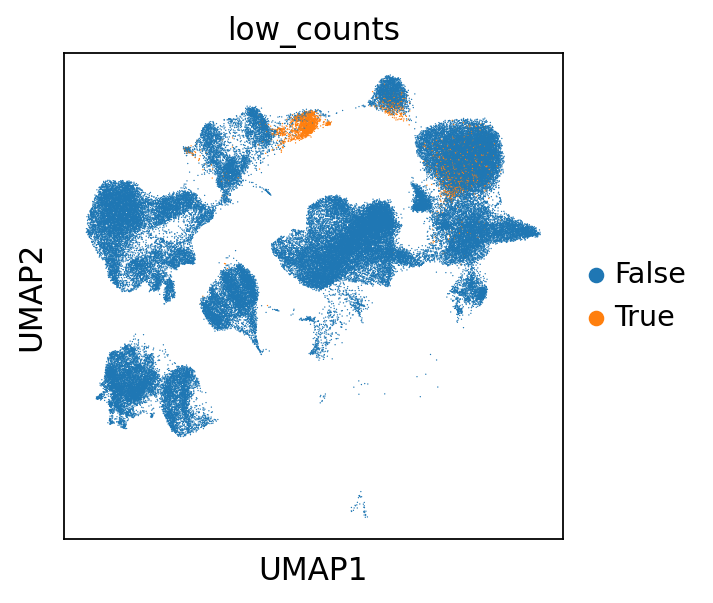

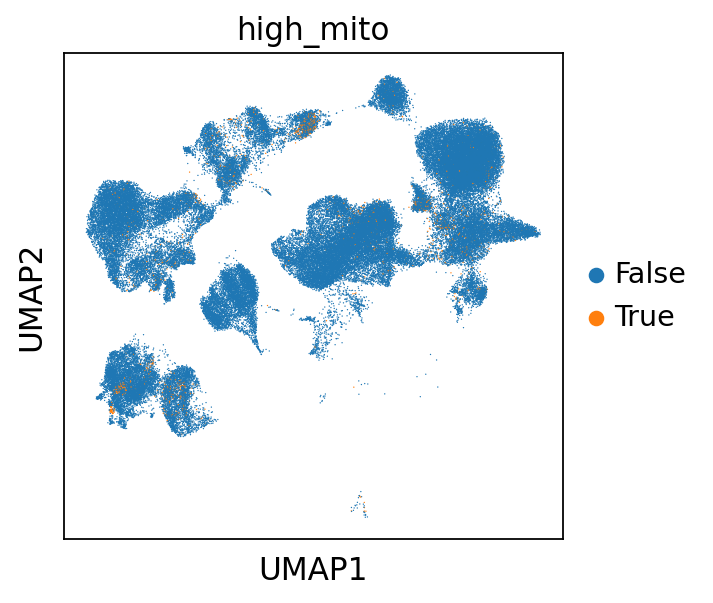

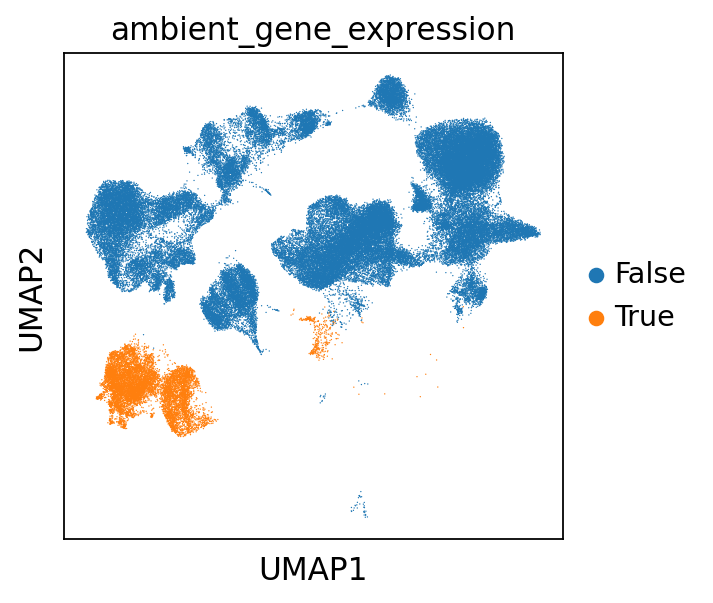

In [25]:
sc.pl.umap(bcells, color = 'low_counts')
sc.pl.umap(bcells, color = 'high_mito')
sc.pl.umap(bcells, color = 'ambient_gene_expression')

In [ ]:
# batch correct and recluster

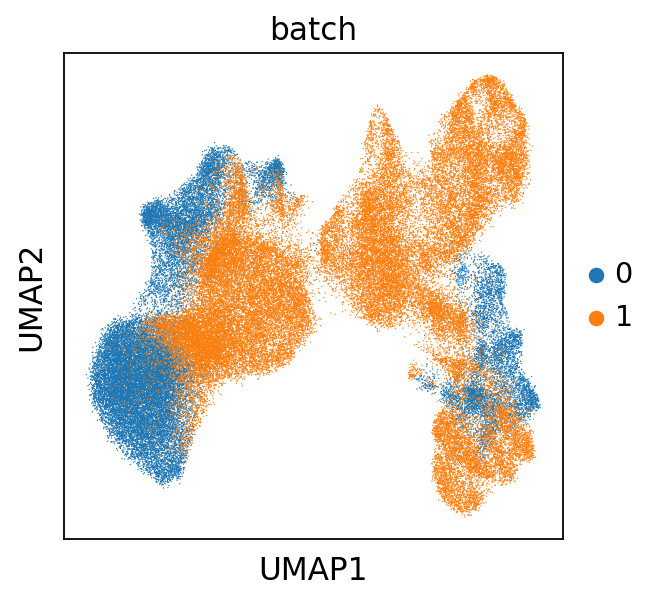

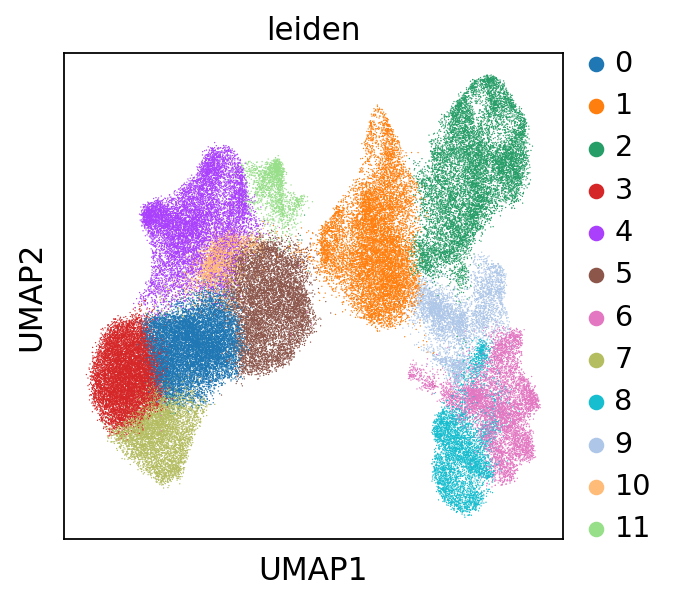

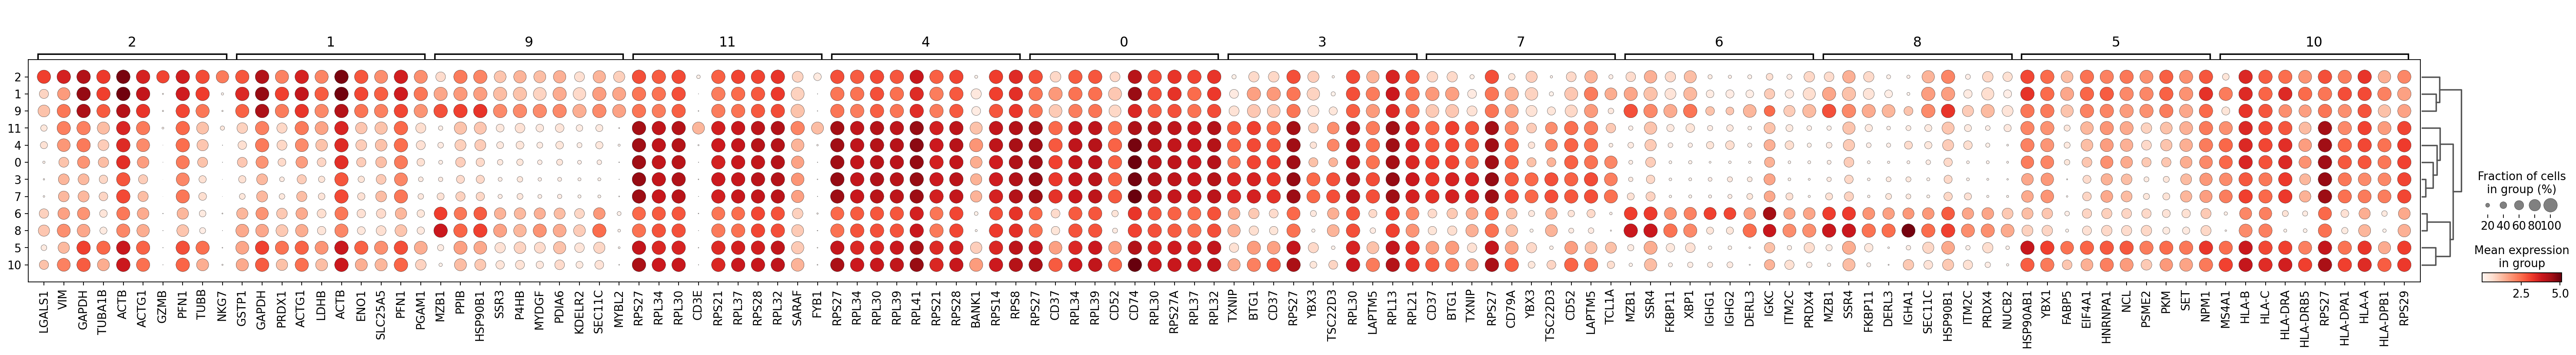

In [28]:
bcells = cluster(bcells, batch_correct=True, batch_key='tissue')

sc.tl.leiden(bcells, resolution=1)

sc.pl.umap(bcells, color='leiden')

sc.tl.rank_genes_groups(bcells, groupby='leiden')

sc.tl.dendrogram(bcells, groupby='leiden')

sc.pl.rank_genes_groups_dotplot(bcells, groupby='leiden')

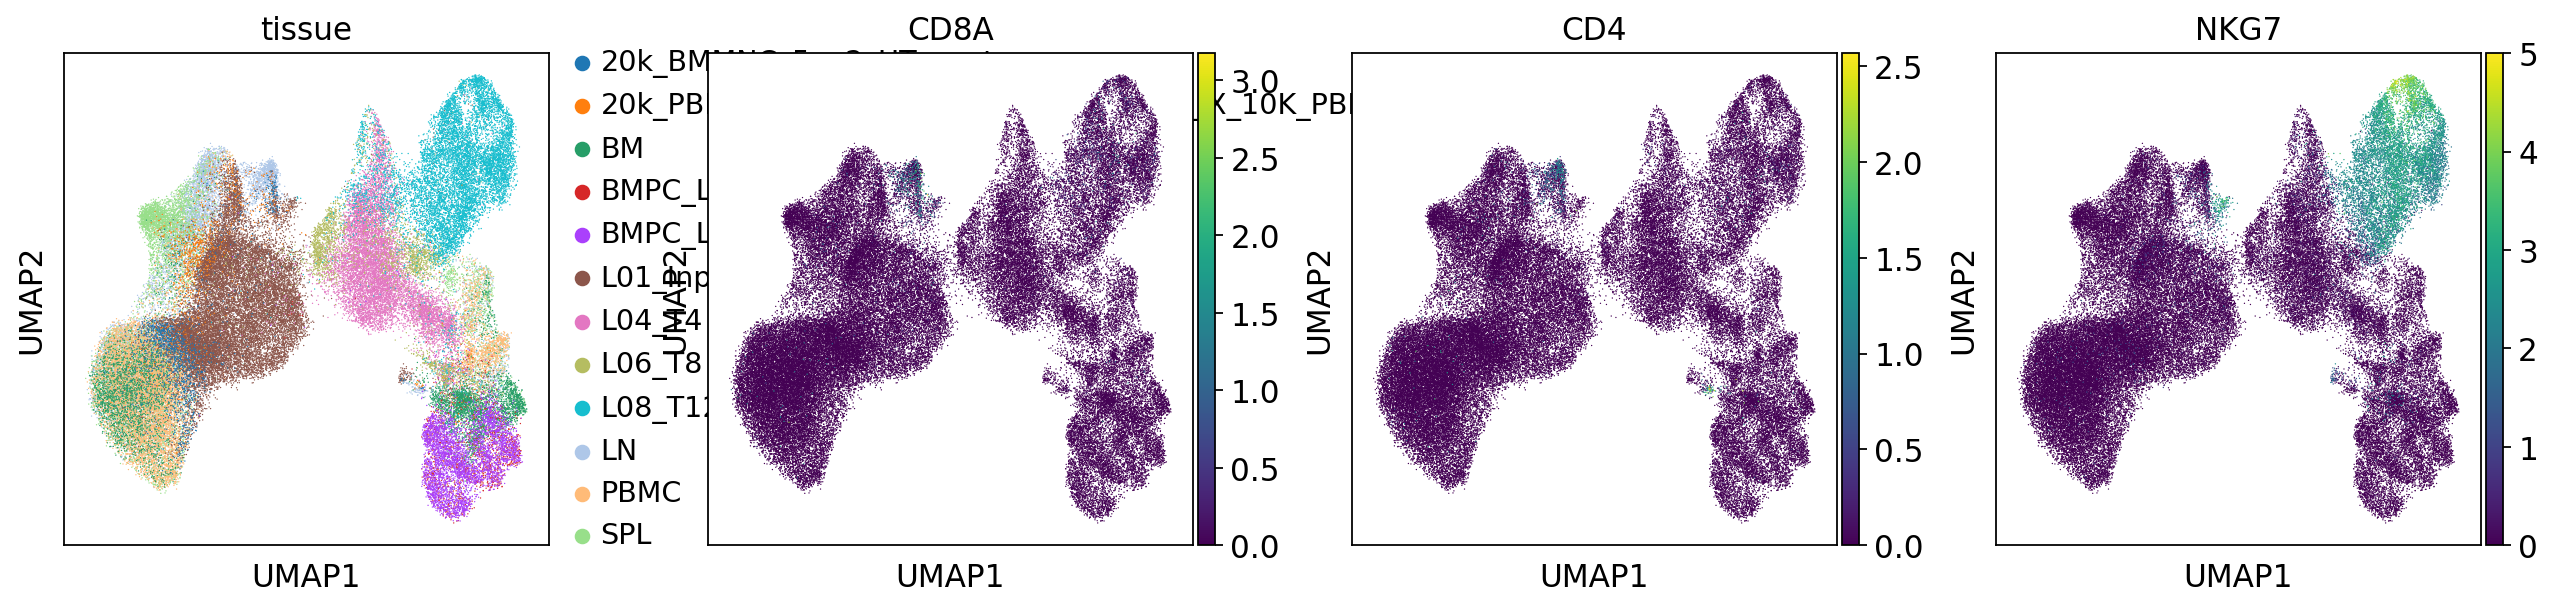

In [54]:
sc.pl.umap(bcells, color = ['tissue', 'CD8A', 'CD4', 'NKG7'])

In [ ]:
# I'm finding cluster 2 & 11 seems to have a lot of NK and T cell genes

In [44]:
bcells.obs['probable_t_cell_doublet'] = (bcells.obs.leiden.isin(['11', '2'])).astype(str)

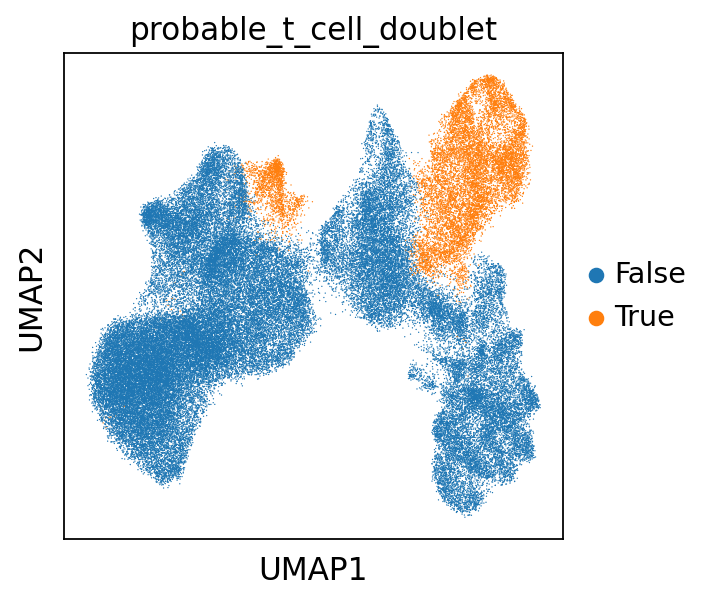

In [48]:
sc.pl.umap(bcells, color = 'probable_t_cell_doublet')

In [49]:
bcells.obs['true_b_cell'] = (bcells.obs['low_counts'] == 'False') & (bcells.obs['high_mito'] == 'False') & (bcells.obs['ambient_gene_expression'] == 'False') & (bcells.obs['probable_t_cell_doublet'] == 'False')
bcells.obs['true_b_cell'].value_counts()

True     67013
False    16023
Name: true_b_cell, dtype: int64

In [55]:
bcells.write_h5ad('../../data/processed_h5ad/filtered_bcells.h5ad')

In [51]:
bcells.obs.groupby('true_b_cell').tissue.value_counts()

true_b_cell                                              
False        L08_T12                                          9233
             BM                                               1752
             LN                                               1595
             L01_Input                                         819
             L06_T8                                            776
             PBMC                                              640
             SPL                                               543
             L04_T4                                            251
             20k_BMMNC_5pv2_HT_nextgem                         230
             20k_PBMC_5pv2_HT_nextgem_Chromium_X_10K_PBMC      175
             BMPC_L2                                             7
             BMPC_L1                                             2
True         L01_Input                                       18710
             L04_T4                                           9722
    

In [29]:
# understand the failure modes:
    # dead cells
    # they look dead bc
    # there's these age-associated B cells but are they really?
    # the bone marrow seems stressed?
    # what kinds of artefacts exist